# Overview

This notebook serves as an overview for people getting started with Eidolon who want to dive deeper into the Git Search example.

For more in-depth documentation, check out the [Git Search documentation](https://www.eidolonai.com/docs/recipes/repo-expert/).

[skip to code](#Prerequisite)

## Problem Statement
I want to be able to ask questions to somebody (or something) that is familiar with a github project.

## Solution
In this repository we use Eidolon to build a LLM chatbot that can answer questions about a github repository.

We cannot load the entire repository into the LLM, since it will not fit in the context window (or be prohibitively expensive). So 
instead we will allow our chatbot to dynamically retrieve documents via searches on a vector db. We will dynamically syncronize the 
db embeddings with the repository so information is always up to date without needing to manage an embedding data pipeline.

## Architecture
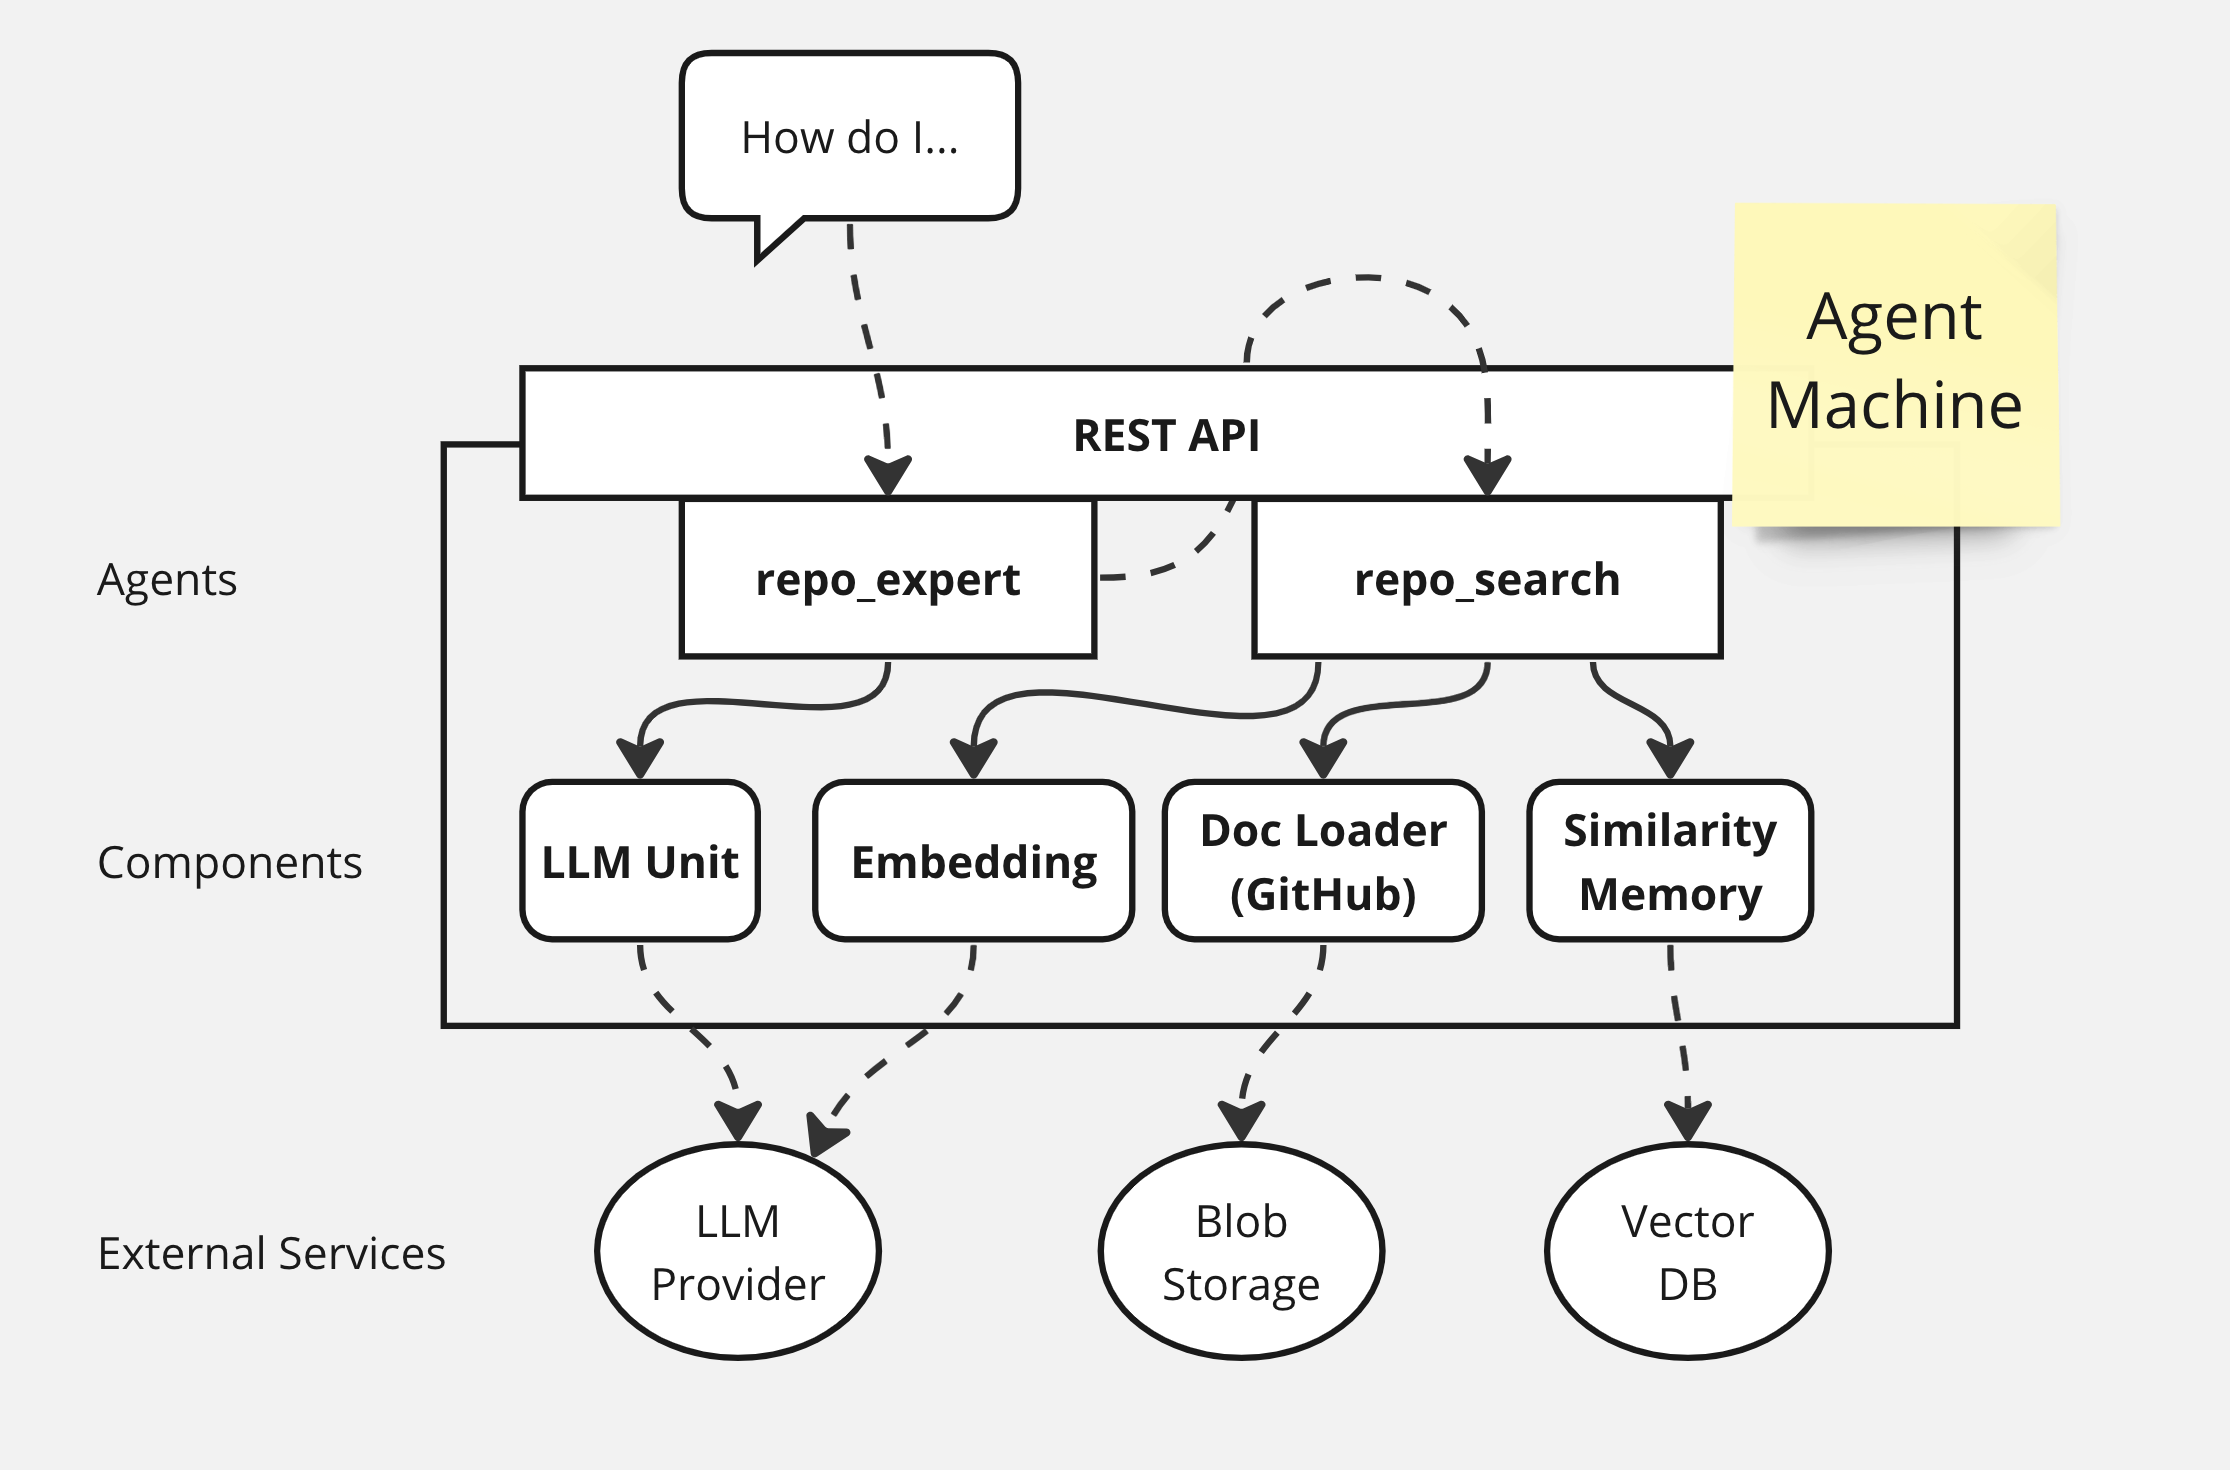

## Chatbot (repo_expert)
This is the user facing Chatbot. It requests more context as needed from the repo_search agent, and is responsible for answering user questions.

### agent_refs
This enables the repo_expert agent to interact with other agents. In this case it only needs to work with the repo_search agent.

### system_prompt
This is a prompt designed to help the agent understand its role.

In [35]:
with open('resources/repo_expert.yaml', 'w') as file:
    file.write("""
apiVersion: eidolon/v1
kind: Agent
metadata:
  name: repo_expert

spec:
  agent_refs: [repo_search]
  system_prompt:
    You are a software documentation assistant responsible for maintaining a project and trying to prove yourself.
    Your job is to write documentation for the project including how to use it, what each component does, and the details of each part of the code.
    Your responsibility is to learn how to use a project and help answer user questions.
    You have available tools that can search for code, documentation, and list files.
    You can use these tools to help build your understanding of the project.
    Use your code_search and/or example_search tools when more information would be helpful.
    Think carefully.
    """.strip() + "\n")

## Dynamic RAG component (repo_search)
This is the agent responsible for the vector db search. It will take a question and respond with the most relevent snippets of documents.

It chunks the documents provided via a loader, creates embeddings, and stores them in a Vector DB. This example uses chroma, but you don't need to worry about that detail. Moreover, as those files change it will re-embed them to keep your files and vector db in sync. This convenience makes it a good choice for frequently changing document stores, but suffers from performance issues with large data lakes. Those should be managed with a more traditional embedding pipeline.

### implementation
This agent uses a different type of agent template called _RetrieverAgent_.

### document_manager.loader
The document manager is the component that keeps documents in sync with the vector store. It defines a loader which describes how to access those documents. Since we want to load documents from github, we will need to use the GitHubLoader to load documents.

We need to point the owner/repo at the desired github repository, and then can define patterns to restrict the files we want to chunk. In this example we want all python and md files, and yaml files from two of our example directories. Similarly, we want to exclude all test files.



with open('resources/repo_expert.yaml', 'w') as file:
    file.write("""
apiVersion: eidolon/v1
kind: Agent
metadata:
  name: repo_search

spec:
  implementation: RetrieverAgent
  name: "example_search"
  description: "Search the Eidolon github repository for code, examples, and documentation"
  document_manager:
    loader:
      implementation: GitHubLoader
      owner: "eidolon-ai"
      repo: "eidolon"
      pattern:
        - "examples/**/getting_started/**/*.yaml"
        - "examples/**/git_search/**/*.yaml"
        - "**/*.md"
        - "**/*.py"
      exclude: "**/test/**/*"
    """.strip() + "\n")

# Prerequisite
envars: GITHUB_TOKEN, OPENAI_API_KEY

python: 3.11

In [19]:
import subprocess
completed_process = subprocess.run(["make", "check"])

👍 OPENAI_API_KEY set
👍 GITHUB_TOKEN set


### 🚨 Check not working?
This walkthrough will require you to have GITHUB_TOKEN and OPENAI_API_KEY set as envars.

If you don't have already, we will need to create them. Open up .env in your favorite text editor to fill them in.

In [2]:
%%capture
subprocess.run(["subl", ".env"])
# subprocess.run(["open", ".env"])

# Run the Machine

In [20]:
import subprocess
machine = None

In [21]:
if machine:
    machine.terminate()
machine = subprocess.Popen(["make", "serve-dev"])

poetry run eidolon-server -m local_dev resources


INFO:     Started server process [29685]
INFO:     Waiting for application startup.


INFO - Building machine 'local_dev'
INFO - Starting agent 'repo_search'
INFO - Starting agent 'repo_expert'
INFO - Server Started


# Try it out!

In [24]:
from eidolon_ai_client.client import Agent
agent = Agent(agent="repo_expert")

process = await agent.create_process()
response = await process.action("converse", "How do I define a new agent in Eidolon? Be Concise")

INFO - Request: POST http://localhost:8080/processes
INFO - Response: 200
INFO - Request: POST http://localhost:8080/processes/664689c23a02909b9575df54/agent/repo_expert/actions/converse
INFO - Request: GET http://localhost:8080/agents/repo_search/programs
INFO - Response: 200
INFO - executing open ai llm request
INFO - open ai llm tool calls: [{"id": "call_5rgGZPCNWbi9G1wmBfDsmNXt", "name": "AgentsLogicUnit_convo_repo_search_search", "arguments": "{\"body\":{\"question\":\"How do I define a new agent in Eidolon?\"}}"}]
INFO - calling tool convo_repo_search_search
INFO - Request: POST http://localhost:8080/processes
INFO - Response: 200
INFO - Request: POST http://localhost:8080/processes/664689c43a02909b9575df59/agent/repo_search/actions/search
INFO - Syncing files from example_search
INFO - Found 296 files in symbolic memory
INFO - Response: 202
INFO - Added file sdk/eidolon_ai_sdk/cpu/audio_unit.py
INFO - Added file sdk/eidolon_ai_sdk/builtins/logic_units/playwrite_browser.py
INFO -

### Lets look at our response
Above are your server logs, lets take a look to see what actually came back from the http request.

Remember, Eidolon fully supports streaming, but since we are in a notebook we will not stream the response. It would be too confusing to read interlaced with the server logs.

In [25]:
print(response.data)

To define a new agent in Eidolon, follow these steps:

1. **Define the Agent's Scope**: Determine the specific tasks and domain your agent will handle.
2. **Configure the Service**: Use YAML to configure your agent's settings, including any necessary hyperparameters for behavior modification.
3. **Deployment**:
   - Deploy your agent to a server, either on-premises or in the cloud.
   - Eidolon provides built-in deployment services, making the process straightforward.
   - Test your deployment to ensure everything is functioning as expected.

Eidolon emphasizes easy deployment, simple agent-to-agent communication, and painless component customization, allowing for modular and flexible agent services.


# What Next?
You now have a chatbot running that you can ask questions about the Eidolon project. That's great! But perhaps you don't honestly care about Eidolon. It's alright, I'm not offended. 

Let's modify the project to work against a more DataScience specific repository: [Recommenders](https://github.com/recommenders-team/recommenders).

In [42]:
with open('resources/repo_search.yaml', 'w') as file:
    file.write("""
apiVersion: eidolon/v1
kind: Agent
metadata:
  name: repo_search

spec:
  implementation: RetrieverAgent
  name: "Reccomenders"
  description: "Recommenders objective is to assist researchers, developers and enthusiasts in prototyping, experimenting with and bringing to production a range of classic and state-of-the-art recommendation systems."
  document_manager:
    loader:
      implementation: GitHubLoader
      owner: "recommenders-team"
      repo: "recommenders"
    """.strip() + "\n")

if machine:  # let's also restart the machine so our changes take effect
    machine.terminate()
machine = subprocess.Popen(["make", "serve-dev"])

poetry run eidolon-server -m local_dev resources


INFO:     Started server process [30596]
INFO:     Waiting for application startup.


INFO - Building machine 'local_dev'
INFO - Starting agent 'repo_search'
INFO - Starting agent 'repo_expert'
INFO - Server Started


In [44]:
process = await agent.create_process()
response = await process.action("converse", "Do you know of any projects that will help me save the penguins?")

INFO - Request: POST http://localhost:8080/processes
INFO - Response: 200
INFO - Request: POST http://localhost:8080/processes/6646a60ea1f07ab169594755/agent/repo_expert/actions/converse
INFO - Request: GET http://localhost:8080/agents/repo_search/programs
INFO - Response: 200
INFO - executing open ai llm request
INFO - open ai llm tool calls: [{"id": "call_2fp8HOaqkTBzwTasFLUmUGwU", "name": "AgentsLogicUnit_convo_repo_search_search", "arguments": "{\"body\":{\"question\":\"save the penguins\"}}"}]
INFO - calling tool convo_repo_search_search
INFO - Request: POST http://localhost:8080/processes
INFO - Response: 200
INFO - Request: POST http://localhost:8080/processes/6646a610a1f07ab16959475a/agent/repo_search/actions/search
INFO - executing open ai llm request
INFO - Response: 202
INFO - open ai llm tool calls: []
INFO - LLM Response: {'questions': ['How can we protect penguin populations?', 'What are effective methods to conserve penguin habitats?', 'What actions can be taken to preve

In [45]:
print(response.data)

I couldn't find any specific projects related to saving penguins in the current repository. However, there might be projects focusing on environmental conservation, wildlife protection, or climate change that indirectly contribute to the well-being of penguin populations. If you have a specific aspect or approach in mind regarding penguin conservation, please let me know, and I can help you find or start a project related to that!
